In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
class Balls:
    
    def __init__(self, N, dim, boundary, T):
        
        self.N        = N
        self.T        = T
        self.dim      = dim
        self.boundary = boundary
        
        np.random.seed(0)
        self.pos = 2*np.random.rand(N,dim)-1
        
        np.random.seed(0)
        self.vel = 2*np.random.rand(N,dim)-1
        
        self.rad  = np.ones(N)
        self.mass = np.ones(N)
        
        self.t      = [0]
        self.tc     = []
        self.tc_all = np.full((N,2*dim+N), float(T))
        
        self.results_pos = []
        self.results_vel = []
        
        return
    
    def evolve(self):
        
        t       = self.t[0]
        T       = self.T
        modify  = self.modify
        record  = self.record
        iterate = self.iterate
        
        record()
        
        while t < T:
    
            iterate()
            
            t = self.t[-1]
            print(t)
        
        modify() # To calculate the last free path, i.e. t=T. 
        
        return
    
    def iterate(self):
        
        move             = self.move
        tc_BC            = self.tc_boundary
        record           = self.record
        tc_min           = self.tc_min
        collide_BC       = self.collide_boundary
        tc_balls_2D      = self.tc_balls_2D
        collide_balls_2D = self.collide_balls_2D
        
        tc_BC()
        
        #tc_balls_2D()
        
        tc_min()
                
        move()
            
        collide_BC()
        
        #collide_balls_2D()
                
        self.t.append(self.t[-1]+self.tc[-1])
            
        record()
        
        return
    
    def record(self):
        
        pos = self.pos
        vel = self.vel
        
        self.results_pos.append(pos)
        self.results_vel.append(vel)
        
        return
    
    def modify(self):
        
        T      = self.T
        move   = self.move
        record = self.record
        
        self.t.pop()
        self.tc.pop()
        self.results_pos.pop()
        self.results_vel.pop()
        
        self.tc.append(T-self.t[-1])
        self.t.append(self.t[-1]+self.tc[-1])
        
        move()
        
        self.tc.pop()
        
        record()
        
        return
    
    def move(self):
        
        dt  = self.tc[-1]
        pos = self.pos
        vel = self.vel
        
        pos = pos + vel*dt
        
        self.pos = pos
        
        return
    
    def tc_boundary(self):
        
        T     = self.T
        BC    = self.boundary
        dim   = self.dim
        pos   = self.pos
        vel   = self.vel
        tc_BC = self.tc_all[:,0:2*dim] # tc for boundary
    
        tc_BC[:,0:dim]     = (BC - pos)/vel
        tc_BC[:,dim:2*dim] = (-BC - pos)/vel
        tc_BC[tc_BC<=0]    = T
        
        self.tc_all[:,0:2*dim] = tc_BC
        
        return
    
    def tc_balls_2D(self):
        
        R   = self.rad
        T   = self.T
        dim = self.dim
        pos = self.pos
        vel = self.vel
        
        x  = pos[:,0]
        y  = pos[:,1]
        vx = vel[:,0]
        vy = vel[:,1]

        xi, xj   = np.meshgrid(x,x,indexing='ij')
        yi, yj   = np.meshgrid(y,y,indexing='ij')
        vxi, vxj = np.meshgrid(vx,vx,indexing='ij')
        vyi, vyj = np.meshgrid(vy,vy,indexing='ij')

        Ri, Rj = np.meshgrid(R,R,indexing='ij')

        xij  = xj - xi
        yij  = yj - yi
        vxij = vxj - vxi
        vyij = vyj - vyi

        Rij = Rj + Ri

        r_d_v  = xij*vxij + yij*vyij # r dot v
        r_s    = xij**2 + yij**2     # r square
        v_s    = vxij**2 + vyij**2   # v square
        R_s    = Rij**2              # R square
        
        J = np.full(Rij.shape,True)
        J = np.triu(J, k=1)          # upper triangle to speedup
        D = r_d_v**2-v_s*(r_s-R_s)
        J = J&(D>0)

        tc_balls              = np.zeros(Rij.shape)
        tc_balls[J]           = (-r_d_v[J] - np.sqrt(D[J]))/v_s[J]
        tc_balls              = tc_balls + tc_balls.T
        tc_balls[tc_balls<=0] = T
        
        self.tc_all[:,2*dim:] = tc_balls
        
        return
    
    def tc_min(self):
        
        tc_all = self.tc_all
        
        self.tc.append(np.min(tc_all))
        
        self.collision_index = tc_all==np.min(tc_all)
        
        return
    
    def collide_boundary(self):
        
        dim   = self.dim
        vel   = self.vel
        index = self.collision_index
        
        vel[index[:,0:dim]]      = -vel[index[:,0:dim]]
        vel[index[:,dim:2*dim]]  = -vel[index[:,dim:2*dim]]
        
        self.vel = vel
    
        return
    
    def collide_balls_2D(self):
        
        i   = self.collision_index[:,2*dim:]
        m   = self.mass
        pos = self.pos
        vel = self.vel
        
        x  = pos[:,0]
        y  = pos[:,1]
        vx = vel[:,0]
        vy = vel[:,1]
        
        xi, xj   = np.meshgrid(x,x,indexing='ij')
        yi, yj   = np.meshgrid(y,y,indexing='ij')
        mi, mj   = np.meshgrid(m,m,indexing='ij')
        vxi, vxj = np.meshgrid(vx,vx,indexing='ij')
        vyi, vyj = np.meshgrid(vy,vy,indexing='ij')

        xij  = xi - xj
        yij  = yi - yj
        vxij = vxi - vxj
        vyij = vyi - vyj
        
        C    = np.zeros(mi.shape)
        C[i] = 2*mj[i]/(mi[i]+mj[i])*(vxij[i]*xij[i]+vyij[i]*yij[i])/(xij[i]**2+yij[i]**2)
        
        vx_f    = np.zeros(mi.shape)
        vx_f[i] = vxi[i] - C[i]*xij[i]
        vy_f    = np.zeros(mi.shape)
        vy_f[i] = vyi[i] - C[i]*yij[i]
        
        vx_f = np.sum(vx_f,axis=1)
        vy_f = np.sum(vy_f,axis=1)
        
        vx[vx_f!=0] = vx[vx_f!=0]
        vy[vy_f!=0] = vy[vy_f!=0]
        
        vel[:,0] = vx
        vel[:,1] = vy
        
        self.vel = vel
        
        return


In [3]:
numbers  = 10                  # particle numbers
dim      = 2                   # dimension
boundary = 2                   # boundary
T        = 20                  # total time

balls = Balls(numbers, dim, boundary, T) # balls

#balls.pos = np.array([[0,np.sqrt(2)],[np.sqrt(2)+1,0]])
#balls.vel = np.array([[1.01,0.01],[0.01,0.01]])
balls.evolve()

1.0842816703786011
1.1567399523727335
1.3311982722811553
1.3496426193863664
1.4220657926975973
1.5524985080741716
1.7026139675093668
2.006435164301937
2.427885403914611
2.595095199326268
3.6470697732774617
5.252845011135803
5.470219857118201
5.854286159874867
5.993594816843466
6.048927858159099
6.266197378092792
6.657495524222515
7.107841902528101
7.579384270675936
8.019305492905811
8.731093296339608
9.283656211743832
9.421408351893003
9.783699761863666
9.785285597978804
10.655991361405775
10.748213096931831
11.110328963487985
11.762492540370857
12.09840030991744
12.513069837546833
12.941209319832385
13.589971692650206
13.696251749196342
14.032175821509684
14.097179666609131
15.022357280155406
15.318387905968084
15.447498335704562
15.954460548883178
16.139427019573052
16.8674895565192
16.975475996631342
17.75853503340741
17.91829777256557
18.410659571354604
19.486134359230487
19.562858479624605
19.9807844505304
20.045046150113563


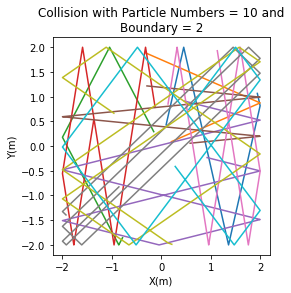

In [4]:
 
N    = balls.N
BC   = balls.boundary
pos  = np.array(balls.results_pos)

for i in range(N):
            
    plt.plot(pos[:,i,0], pos[:,i,1])
        
plt.axis('square')
plt.title(f'Collision with Particle Numbers = {N} and\nBoundary = {BC}')
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.savefig(f'N_{N}_particles_with_boundary.png')
        

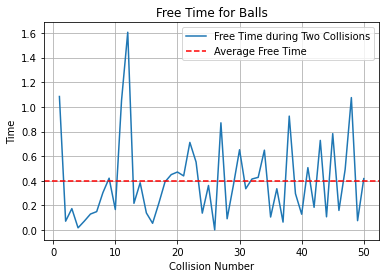

In [5]:

tc = balls.tc
x = [i+1 for i in range(len(tc))]
plt.plot(x,tc,label='Free Time during Two Collisions')
plt.axhline(y=np.sum(tc)/len(tc), color='r', linestyle='--',label='Average Free Time')
plt.grid()
plt.legend()
plt.title('Free Time for Balls')
plt.xlabel('Collision Number')
plt.ylabel('Time');


In [6]:
r = np.array([[0,0],[1,0.4]])
v = np.array([[1,0],[0,0]])
R = np.array([0.2,0.2])

x = r[:,0]
y = r[:,1]

vx = v[:,0]
vy = v[:,1]

xi, xj = np.meshgrid(x,x,indexing='ij')
yi, yj = np.meshgrid(y,y,indexing='ij')

vxi, vxj = np.meshgrid(vx,vx,indexing='ij')
vyi, vyj = np.meshgrid(vy,vy,indexing='ij')

Ri, Rj = np.meshgrid(R,R,indexing='ij')

xij = xj - xi
yij = yj - yi

vxij = vxj - vxi
vyij = vyj - vyi

Rij = Rj + Ri

r_d_v  = xij*vxij + yij*vyij # r dot v
r_s    = xij**2 + yij**2     # r square
v_s    = vxij**2 + vyij**2   # v square
R_s    = Rij**2              # R square


T = np.full(r_s.shape,True)
T = np.triu(T, k=1) # upper triangle to speedup
D = r_d_v**2-v_s*(r_s-R_s)
J = T&(D>=0)

tc = np.zeros(Rij.shape)
tc[J] = (-r_d_v[J] - np.sqrt(D[J]))/v_s[J]
print(tc)

[[0. 1.]
 [0. 0.]]


In [7]:
v = np.array([1,0])
m = np.array([1,3])

vi, vj = np.meshgrid(v,v,indexing='ij')
mi, mj = np.meshgrid(m,m,indexing='ij')

vij = (vi*(mi-mj)+2*mj*vj)/(mi+mj)

print(vij)

[[ 1.  -0.5]
 [ 0.5  0. ]]


In [8]:
a = np.arange(8.).reshape(2,2,2)
b = np.arange(8.).reshape(2,2,2)
c = np.dot(a,b)

print('a=',a)
print('b=',b)
print('c=',c)

a= [[[0. 1.]
  [2. 3.]]

 [[4. 5.]
  [6. 7.]]]
b= [[[0. 1.]
  [2. 3.]]

 [[4. 5.]
  [6. 7.]]]
c= [[[[ 2.  3.]
   [ 6.  7.]]

  [[ 6. 11.]
   [26. 31.]]]


 [[[10. 19.]
   [46. 55.]]

  [[14. 27.]
   [66. 79.]]]]
